In [1]:
!nvidia-smi
!pip install -q --upgrade scikit-image numpy torch torchvision
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from skimage import color

Mon Apr 29 13:54:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Preprocessing

In [3]:
def rgb2lab(img):
    img = np.array(img)
    img_lab = color.rgb2lab(img)
    return torch.from_numpy(img_lab.transpose((2, 0, 1))).float()

lab_transform = transforms.Lambda(rgb2lab)
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(), lab_transform])
train_data = datasets.CIFAR10('/mnt/', transform=train_transforms, download=True)
test_data = datasets.CIFAR10('/mnt/', transform=lab_transform, train=False, download=True)
# !mkdir /mnt/imagenet && wget 'http://image-net.org/small/train_32x32.tar' -o /mnt/imagenet/ && cd /mnt/imagenet && tar xf train_32x32.tar && rm train_32x32.tar
# supplement_data = datasets.ImageFolder('/mnt/imagenet')


  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:05, 29158788.64it/s]                               


Files already downloaded and verified


# Image display routines

In [0]:
def show_example(model):
    idx = random.randint(0,len(test_data))
    example_lab, example_class = test_data[idx]
    example_lab = example_lab.numpy().astype(np.float64)
    example_gray = example_lab[0:1,:,:]
    example_ab = example_lab[1:3,:,:]


    with torch.no_grad():
        example_output, example_output_class = model(torch.from_numpy(np.array([example_gray])).float().cuda())
        example_output = example_output[0].cpu().numpy().astype(np.float64)

    grayscale = np.repeat(example_gray.transpose((1,2,0)), 3, axis=2)
    grayscale = (grayscale*2.55).astype(np.uint8)

    colorized = np.concatenate((example_gray, example_output),axis=0).transpose((1,2,0))
    colorized = color.lab2rgb(colorized)*255
    colorized = colorized.astype(np.uint8)

    original = np.concatenate((example_gray, example_ab), axis=0).transpose((1,2,0))

    original = color.lab2rgb(original)*255
    original = original.astype(np.uint8)

    plt.imshow(np.concatenate((grayscale, colorized, original), axis=1))
    plt.show()

def show_grid(model):

    
    images = None
    
    for i in range(10):
        imgrow = None
        for j in range(5):
            idx = random.randint(0,len(test_data))
            while test_data[idx][1] != i:
                idx = random.randint(0,len(test_data))
            img_lab, img_class = test_data[idx]
            img_lab = img_lab.numpy().astype(np.float64)
            img_gray = img_lab[0:1,:,:]
            with torch.no_grad():
                img_output, img_output_class = model(torch.from_numpy(np.array([img_gray])).float().cuda())
                img_output = img_output[0].cpu().numpy().astype(np.float64)
            img_rgb = color.lab2rgb(img_lab.transpose((1,2,0)))*255
            img_colorized = color.lab2rgb(np.concatenate((img_gray, img_output), axis=0).transpose((1,2,0)))*255
            
            img_rgb = img_rgb.astype(np.uint8)
            img_colorized = img_colorized.astype(np.uint8)
            
            combined = np.concatenate((img_colorized, img_rgb), axis=1)
            if imgrow is None:
                imgrow = combined
            else:
                imgrow = np.concatenate((imgrow, combined), axis=1)
        if images is None:
            images = imgrow
        else:
            images = np.concatenate((images, imgrow), axis=0)
    
    plt.imshow(images)
    plt.show()

# Minibatches

In [0]:
BATCH_SIZE = 512
train_loader = Data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# Performance criterion

In [0]:
def test_error(model):
    class_error = 0
    color_error = 0
    
    with torch.no_grad():
        for i, (img, clas) in enumerate(test_loader):
            if torch.cuda.is_available():
                img = img.cuda()
                clas = clas.cuda()
            output, output_class = model(img[:,0:1,:,:])
            
            pred_class = output_class.argmax(dim=1, keepdim=True)
            class_error += pred_class.eq(clas.view_as(pred_class)).sum().item()
            
            color_error += (output - img[:,1:3,:,:]).abs().sum().item()
            if i + 1 == 8:
                break
    
    class_error = 1 - class_error / (8 * BATCH_SIZE)
    color_error = color_error / (8 * BATCH_SIZE)
            
    return color_error, class_error


# Model

In [0]:
class ColorizeNet(nn.Module):
    def __init__(self):
        super(ColorizeNet, self).__init__()
        self.color_encoder = nn.Sequential(
            nn.Conv2d(1,   32,  4, 2, 1), nn.BatchNorm2d(32),  nn.ReLU(inplace=True),   
            nn.Conv2d(32,  64,  4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),            
            nn.Conv2d(64,  128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
        )
    
        self.mid = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 2, 2), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
        )

        self.glob = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
        )
        
        self.glob_linear = nn.Sequential(
            nn.Linear(128*4*4, 128*4), nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(128*4, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
        )

        
        self.fusion = nn.Sequential(
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128, 10), nn.BatchNorm1d(10), nn.Softmax(),
        )

        self.color_decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64,  4, 2, 1, 0, 2), nn.BatchNorm2d(64),  nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64,  32,  4, 2, 1, 0, 2), nn.BatchNorm2d(32),  nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32,  2,   4, 2, 1, 0, 2)
        )
        

    def forward(self, x):
        glob = self.color_encoder(x)
        glob = self.glob(glob)
        glob = glob.view(-1, 128*4*4)
        glob = self.glob_linear(glob)
        
        mid = self.color_encoder(x)
        mid = self.mid(mid)
        glob_fusion = glob.unsqueeze(2).unsqueeze(2).expand_as(mid)
        fusion = torch.cat((mid, glob_fusion), 1)
        fusion = fusion.permute(2, 3, 0, 1).contiguous().view(-1, 256)
        fusion = self.fusion(fusion)
        fusion = fusion.view(mid.size()[2], mid.size()[3], -1, 128)
        
        output_class = self.classifier(glob)
        
        fusion = fusion.permute(2, 3, 0, 1).contiguous()
        output = self.color_decoder(fusion)
        
        return output, output_class


# Training

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:  0 step:  0 | color loss: 8.967510223 | class loss: 2.305832624
Epoch:  0 step:  25 | color loss: 8.436359406 | class loss: 2.222386599
Epoch:  0 step:  50 | color loss: 8.152093887 | class loss: 2.192779064
Epoch:  0 step:  75 | color loss: 8.347225189 | class loss: 2.186137438


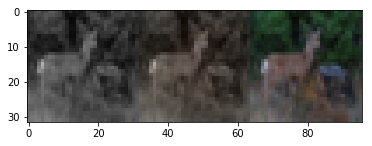

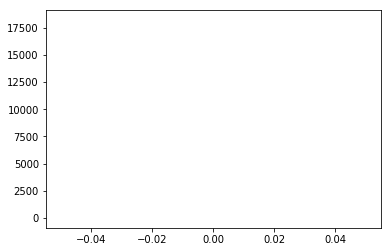

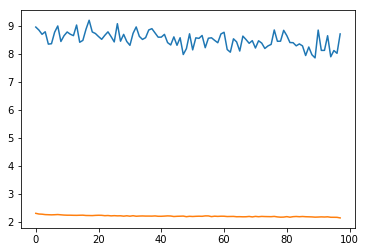

Epoch:  1 step:  0 | color loss: 7.778347492 | class loss: 2.163936615
Epoch:  1 step:  25 | color loss: 8.162499428 | class loss: 2.161061287
Epoch:  1 step:  50 | color loss: 8.196692467 | class loss: 2.144734144
Epoch:  1 step:  75 | color loss: 8.046365738 | class loss: 2.141996622


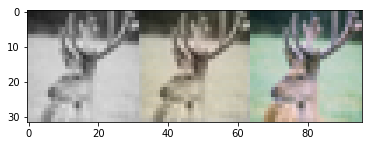

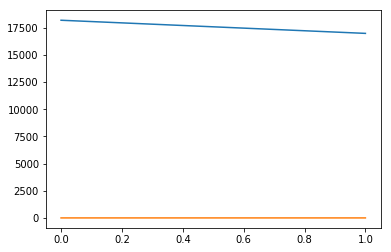

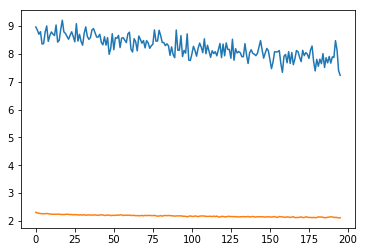

Epoch:  2 step:  0 | color loss: 7.892251492 | class loss: 2.092232704
Epoch:  2 step:  25 | color loss: 7.921852589 | class loss: 2.102414846
Epoch:  2 step:  50 | color loss: 7.847785473 | class loss: 2.081944704
Epoch:  2 step:  75 | color loss: 7.628708363 | class loss: 2.054394722


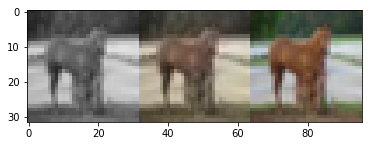

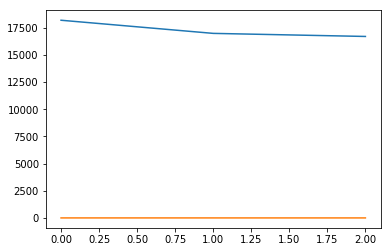

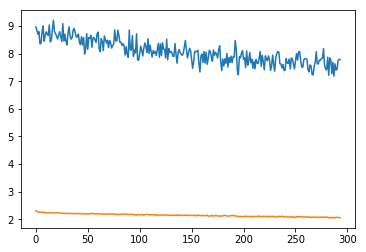

Epoch:  3 step:  0 | color loss: 7.781665802 | class loss: 2.056020975
Epoch:  3 step:  25 | color loss: 7.506500244 | class loss: 2.054840803
Epoch:  3 step:  50 | color loss: 7.599942684 | class loss: 2.048592567
Epoch:  3 step:  75 | color loss: 7.530484676 | class loss: 2.015743732


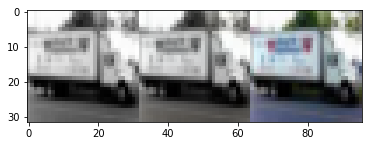

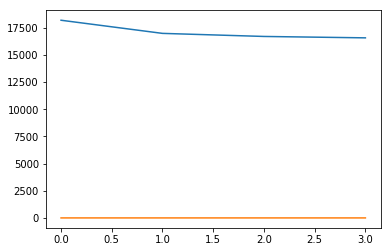

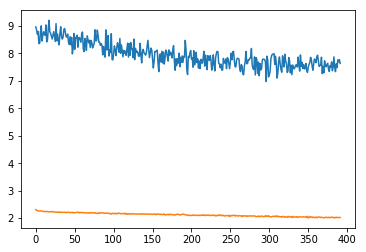

Epoch:  4 step:  0 | color loss: 7.627197266 | class loss: 1.999225259
Epoch:  4 step:  25 | color loss: 7.321230888 | class loss: 1.993412971
Epoch:  4 step:  50 | color loss: 7.696793556 | class loss: 1.992178679
Epoch:  4 step:  75 | color loss: 7.469531059 | class loss: 1.980591893


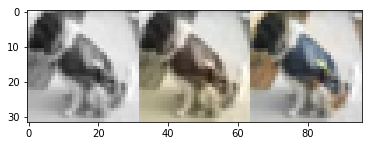

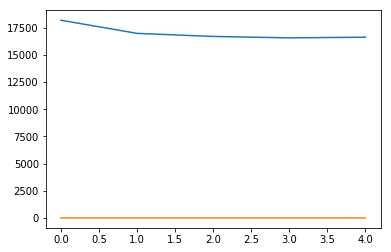

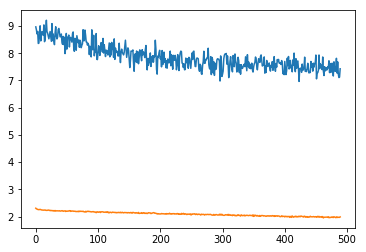

Epoch:  5 step:  0 | color loss: 7.517620087 | class loss: 1.949612021
Epoch:  5 step:  25 | color loss: 7.358520031 | class loss: 1.943637371
Epoch:  5 step:  50 | color loss: 7.369201660 | class loss: 1.961856365
Epoch:  5 step:  75 | color loss: 7.533666134 | class loss: 1.946561456


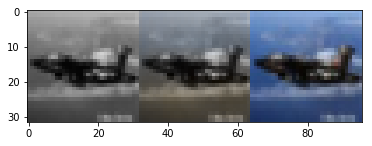

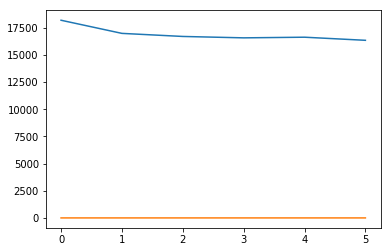

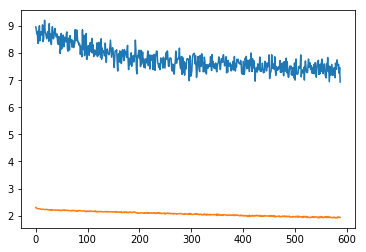

Epoch:  6 step:  0 | color loss: 7.316086292 | class loss: 1.917964935
Epoch:  6 step:  25 | color loss: 7.138743401 | class loss: 1.918562293
Epoch:  6 step:  50 | color loss: 7.255289078 | class loss: 1.888589144
Epoch:  6 step:  75 | color loss: 7.424399376 | class loss: 1.899266601


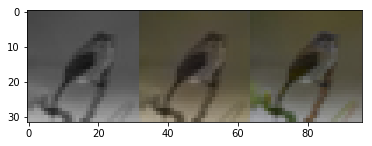

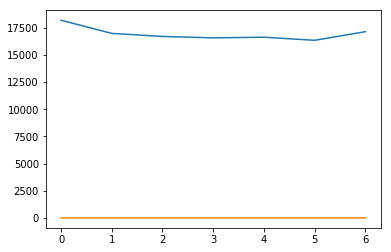

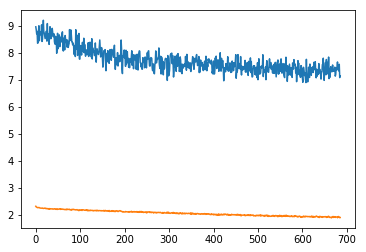

Epoch:  7 step:  0 | color loss: 7.388146400 | class loss: 1.912819028
Epoch:  7 step:  25 | color loss: 6.997602940 | class loss: 1.888137579
Epoch:  7 step:  50 | color loss: 7.254576683 | class loss: 1.870809793
Epoch:  7 step:  75 | color loss: 7.153030872 | class loss: 1.873649240


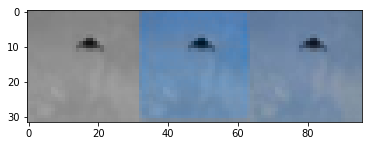

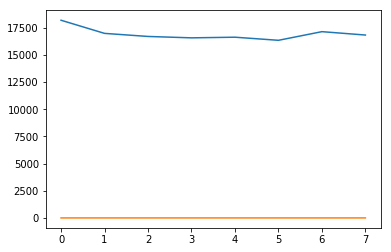

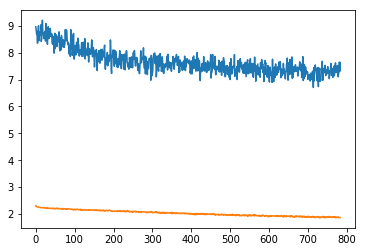

Epoch:  8 step:  0 | color loss: 7.245546341 | class loss: 1.851052642
Epoch:  8 step:  25 | color loss: 7.164525986 | class loss: 1.856744766
Epoch:  8 step:  50 | color loss: 7.134716034 | class loss: 1.886883020
Epoch:  8 step:  75 | color loss: 6.851992130 | class loss: 1.871437550


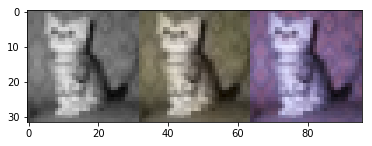

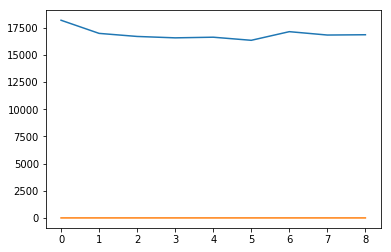

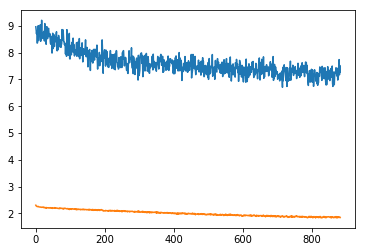

Epoch:  9 step:  0 | color loss: 7.280937195 | class loss: 1.842238307
Epoch:  9 step:  25 | color loss: 7.285358906 | class loss: 1.828284860
Epoch:  9 step:  50 | color loss: 7.122977257 | class loss: 1.837349653
Epoch:  9 step:  75 | color loss: 7.269111633 | class loss: 1.793901205


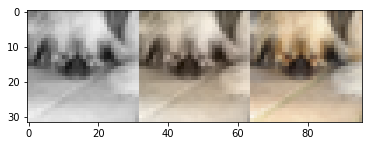

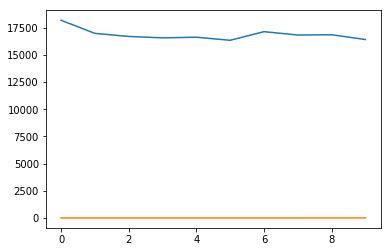

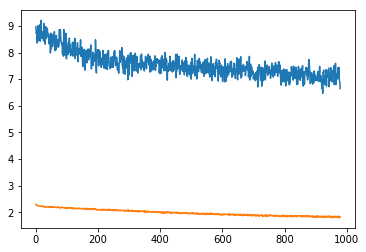

Epoch:  10 step:  0 | color loss: 6.923883915 | class loss: 1.840131164
Epoch:  10 step:  25 | color loss: 7.047203541 | class loss: 1.845409870
Epoch:  10 step:  50 | color loss: 7.213262081 | class loss: 1.810383558
Epoch:  10 step:  75 | color loss: 6.934628010 | class loss: 1.823075056


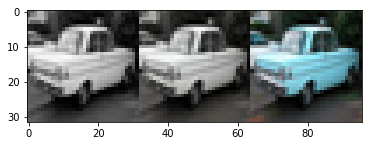

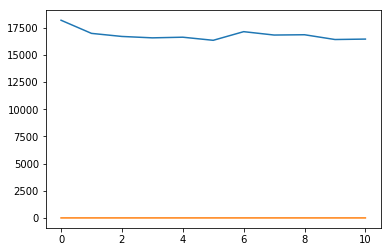

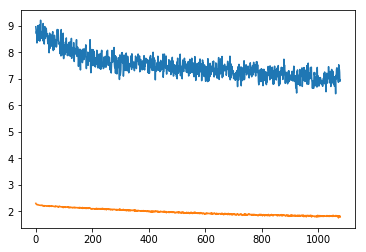

Epoch:  11 step:  0 | color loss: 7.002759933 | class loss: 1.830942512
Epoch:  11 step:  25 | color loss: 6.769381046 | class loss: 1.806626558
Epoch:  11 step:  50 | color loss: 6.672257900 | class loss: 1.811684012
Epoch:  11 step:  75 | color loss: 6.906636715 | class loss: 1.814326644


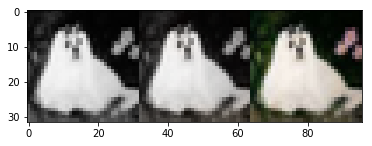

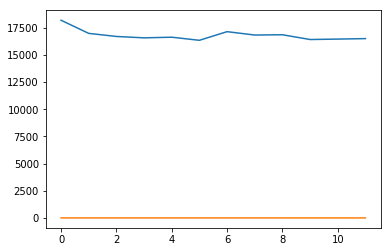

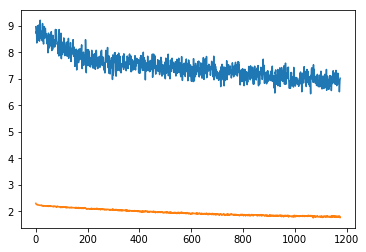

Epoch:  12 step:  0 | color loss: 7.187321186 | class loss: 1.806099653
Epoch:  12 step:  25 | color loss: 6.529711723 | class loss: 1.791649461
Epoch:  12 step:  50 | color loss: 6.808426857 | class loss: 1.785357475
Epoch:  12 step:  75 | color loss: 6.686009407 | class loss: 1.810222507


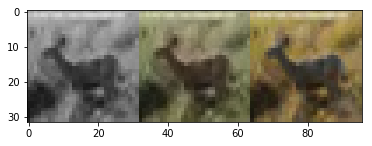

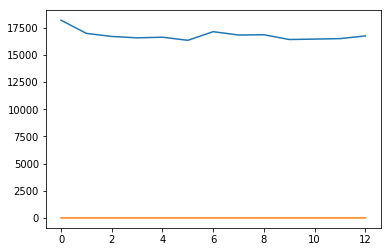

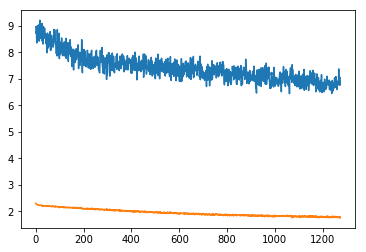

Epoch:  13 step:  0 | color loss: 6.819315910 | class loss: 1.782573938
Epoch:  13 step:  25 | color loss: 6.680971622 | class loss: 1.786398530
Epoch:  13 step:  50 | color loss: 6.827232361 | class loss: 1.760953665
Epoch:  13 step:  75 | color loss: 7.006194115 | class loss: 1.792307377


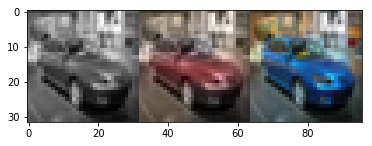

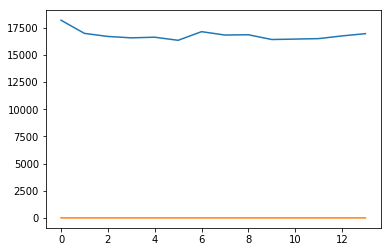

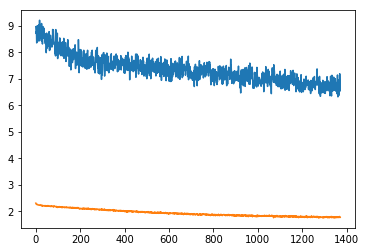

Epoch:  14 step:  0 | color loss: 6.914602757 | class loss: 1.750088215
Epoch:  14 step:  25 | color loss: 6.514773369 | class loss: 1.779721379
Epoch:  14 step:  50 | color loss: 6.324138165 | class loss: 1.776544690
Epoch:  14 step:  75 | color loss: 6.808906555 | class loss: 1.785605907


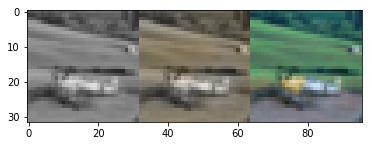

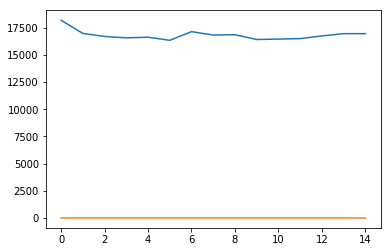

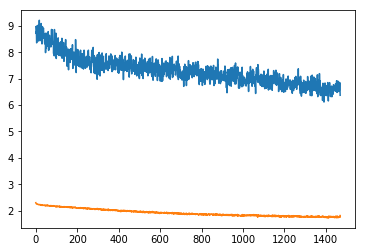

Epoch:  15 step:  0 | color loss: 6.349027634 | class loss: 1.734628320
Epoch:  15 step:  25 | color loss: 6.479285240 | class loss: 1.762399554
Epoch:  15 step:  50 | color loss: 6.427093506 | class loss: 1.746062636
Epoch:  15 step:  75 | color loss: 6.694430351 | class loss: 1.770670176


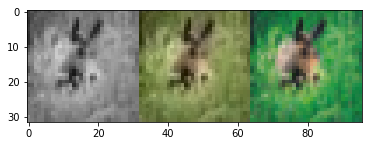

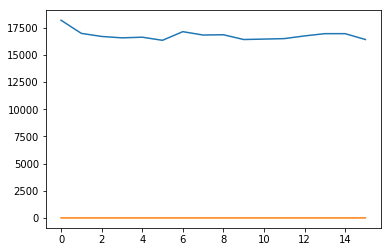

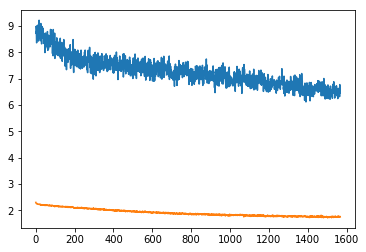

Epoch:  16 step:  0 | color loss: 6.347933292 | class loss: 1.728907824
Epoch:  16 step:  25 | color loss: 6.192854881 | class loss: 1.733370185
Epoch:  16 step:  50 | color loss: 6.460428715 | class loss: 1.756231308
Epoch:  16 step:  75 | color loss: 6.473910332 | class loss: 1.736364365


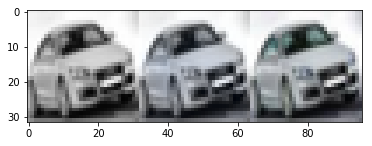

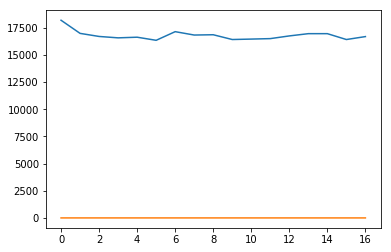

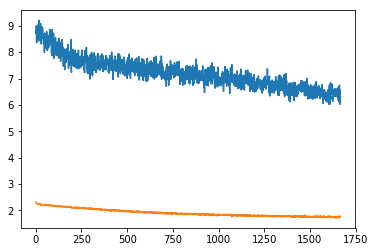

Epoch:  17 step:  0 | color loss: 6.431136608 | class loss: 1.715019107
Epoch:  17 step:  25 | color loss: 6.212246895 | class loss: 1.718010306
Epoch:  17 step:  50 | color loss: 6.043637276 | class loss: 1.726034284
Epoch:  17 step:  75 | color loss: 6.254343510 | class loss: 1.719987273


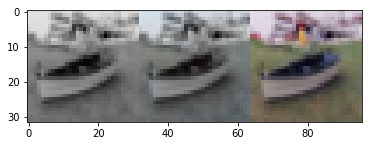

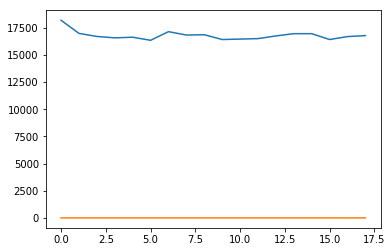

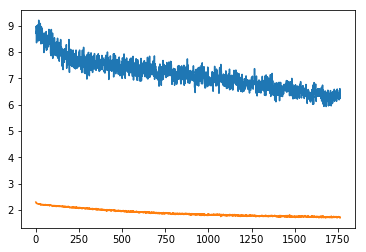

Epoch:  18 step:  0 | color loss: 6.118815422 | class loss: 1.744320869
Epoch:  18 step:  25 | color loss: 6.190485477 | class loss: 1.713313103
Epoch:  18 step:  50 | color loss: 6.152901173 | class loss: 1.699279308
Epoch:  18 step:  75 | color loss: 6.293552876 | class loss: 1.724375963


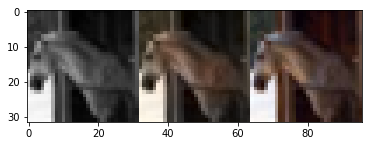

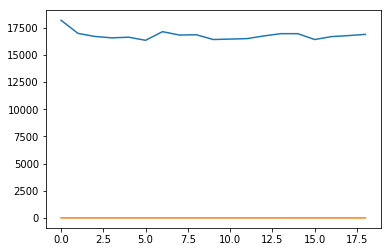

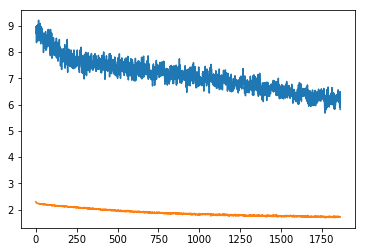

Epoch:  19 step:  0 | color loss: 5.881147385 | class loss: 1.708698392
Epoch:  19 step:  25 | color loss: 6.323803902 | class loss: 1.729503512
Epoch:  19 step:  50 | color loss: 5.804624081 | class loss: 1.708115935
Epoch:  19 step:  75 | color loss: 6.054252625 | class loss: 1.727321982


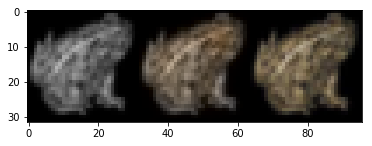

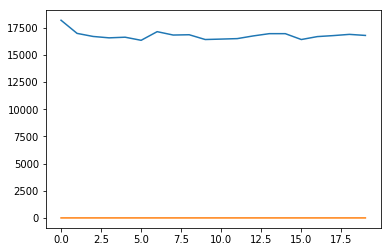

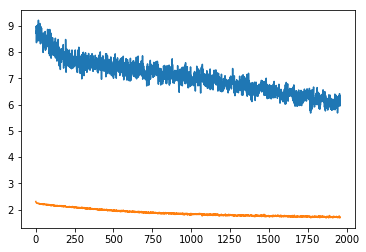

Epoch:  20 step:  0 | color loss: 6.021196365 | class loss: 1.705570340
Epoch:  20 step:  25 | color loss: 5.802116394 | class loss: 1.709758401
Epoch:  20 step:  50 | color loss: 6.027810097 | class loss: 1.750791311
Epoch:  20 step:  75 | color loss: 5.762609482 | class loss: 1.710996985


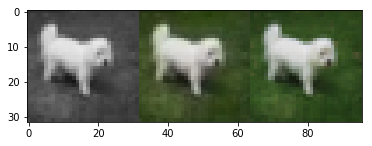

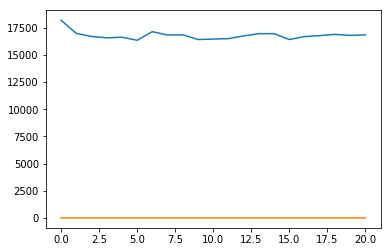

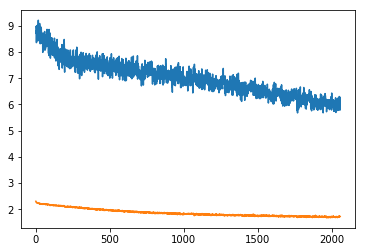

Epoch:  21 step:  0 | color loss: 6.204772472 | class loss: 1.725012779
Epoch:  21 step:  25 | color loss: 6.131869793 | class loss: 1.701559901
Epoch:  21 step:  50 | color loss: 5.732975483 | class loss: 1.712658763
Epoch:  21 step:  75 | color loss: 5.942127228 | class loss: 1.695906043


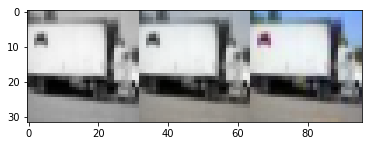

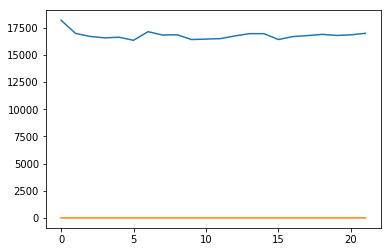

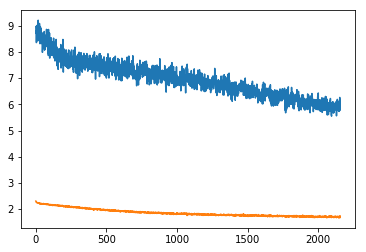

Epoch:  22 step:  0 | color loss: 5.700111866 | class loss: 1.685604334
Epoch:  22 step:  25 | color loss: 5.791666985 | class loss: 1.671060681
Epoch:  22 step:  50 | color loss: 6.046312332 | class loss: 1.677394390
Epoch:  22 step:  75 | color loss: 5.756783485 | class loss: 1.714085221


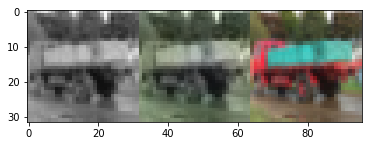

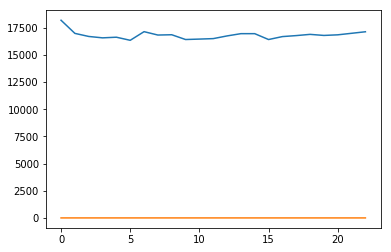

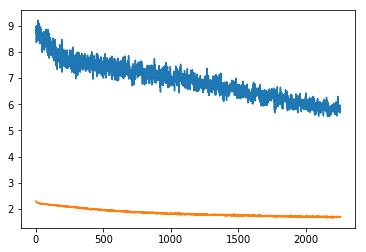

Epoch:  23 step:  0 | color loss: 5.696300030 | class loss: 1.691615582
Epoch:  23 step:  25 | color loss: 5.709352970 | class loss: 1.678037047
Epoch:  23 step:  50 | color loss: 5.861716270 | class loss: 1.673904896
Epoch:  23 step:  75 | color loss: 5.800214767 | class loss: 1.669365764


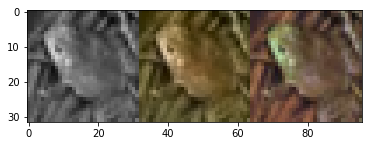

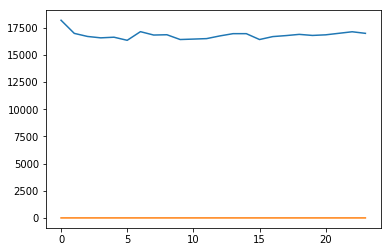

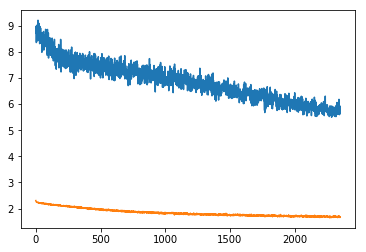

Epoch:  24 step:  0 | color loss: 5.548309803 | class loss: 1.671368837
Epoch:  24 step:  25 | color loss: 5.677240372 | class loss: 1.675012827
Epoch:  24 step:  50 | color loss: 5.645618439 | class loss: 1.650931954
Epoch:  24 step:  75 | color loss: 5.856887817 | class loss: 1.668157935


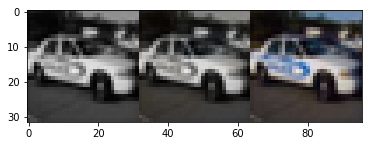

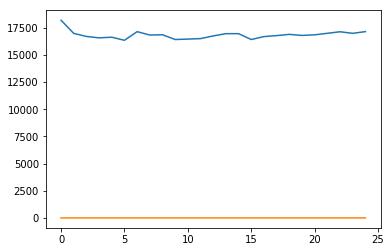

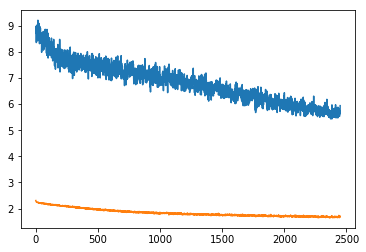

Epoch:  25 step:  0 | color loss: 5.465306759 | class loss: 1.689049840
Epoch:  25 step:  25 | color loss: 5.524913788 | class loss: 1.649299264
Epoch:  25 step:  50 | color loss: 5.739151001 | class loss: 1.651658177
Epoch:  25 step:  75 | color loss: 5.460095882 | class loss: 1.701113701


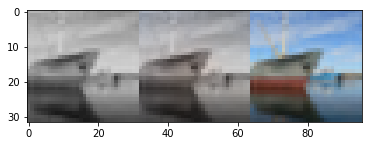

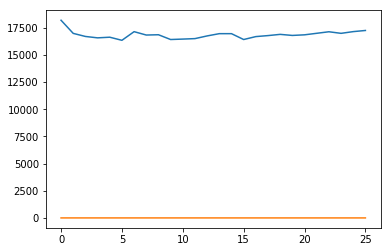

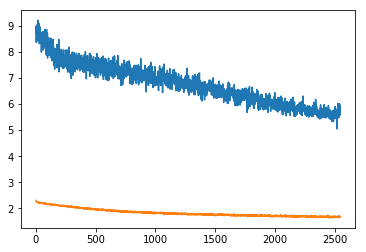

Epoch:  26 step:  0 | color loss: 5.497164249 | class loss: 1.666780114
Epoch:  26 step:  25 | color loss: 5.674618244 | class loss: 1.631246209
Epoch:  26 step:  50 | color loss: 5.666493893 | class loss: 1.658840656
Epoch:  26 step:  75 | color loss: 5.802479744 | class loss: 1.671784759


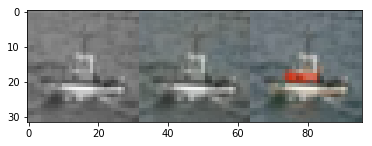

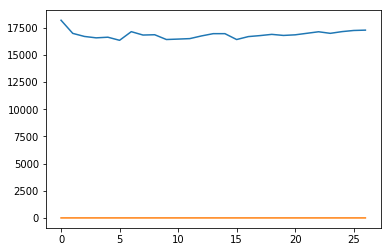

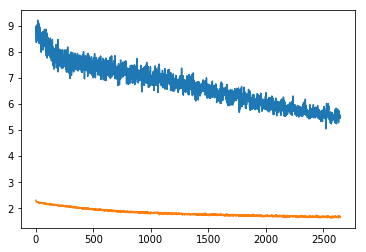

Epoch:  27 step:  0 | color loss: 5.589653492 | class loss: 1.650721192
Epoch:  27 step:  25 | color loss: 5.609323025 | class loss: 1.673856258
Epoch:  27 step:  50 | color loss: 5.294209957 | class loss: 1.673254490
Epoch:  27 step:  75 | color loss: 5.521144390 | class loss: 1.669749498


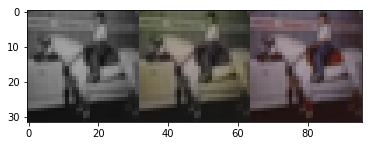

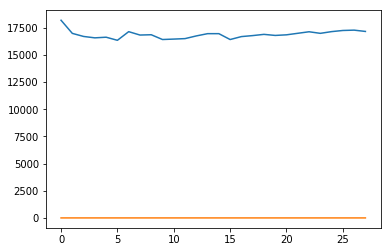

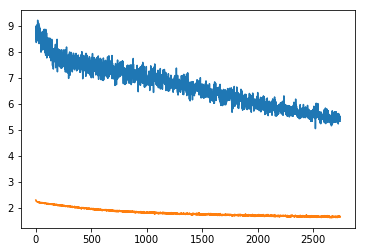

Epoch:  28 step:  0 | color loss: 5.457296848 | class loss: 1.642394662
Epoch:  28 step:  25 | color loss: 5.273443699 | class loss: 1.666584134
Epoch:  28 step:  50 | color loss: 5.296478271 | class loss: 1.638647437
Epoch:  28 step:  75 | color loss: 5.551714897 | class loss: 1.665074348


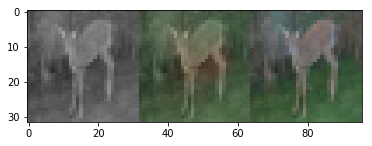

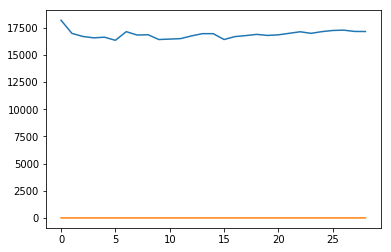

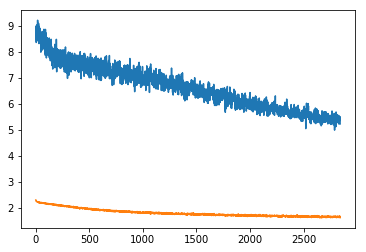

Epoch:  29 step:  0 | color loss: 5.350487232 | class loss: 1.625722408
Epoch:  29 step:  25 | color loss: 5.319708824 | class loss: 1.632634997
Epoch:  29 step:  50 | color loss: 5.361486435 | class loss: 1.648153663
Epoch:  29 step:  75 | color loss: 5.231643200 | class loss: 1.619650722


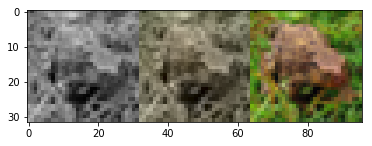

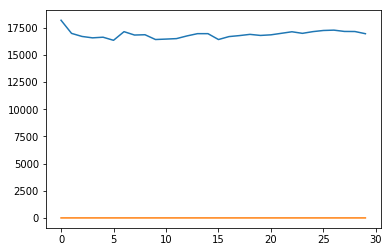

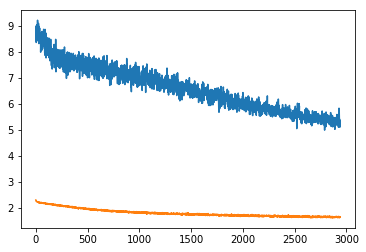

In [51]:
# Hyperparameters
EPOCH = 30
LEARNING_RATE = 1e-3

model = ColorizeNet()

if torch.cuda.is_available():
    model.cuda()


color_criterion = nn.SmoothL1Loss()
class_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# training and testing
model.train()
color_losses = []
color_errors = []
class_losses = []
class_errors = []
for epoch in range(EPOCH):
    for step, (img_lab, clas) in enumerate(
            train_loader
    ):  # gives batch data, normalize x when iterate train_loader
        img_gray = img_lab[:,0:1,:,:]
        img_ab = img_lab[:,1:3,:,:]
        if torch.cuda.is_available():
            img_gray = img_gray.cuda()
            img_ab = img_ab.cuda()
            clas = clas.cuda()
        
        output, output_class = model(img_gray)  # cnn output
        
        color_loss = color_criterion(output, img_ab)
        class_loss = class_criterion(output_class, clas)

        optimizer.zero_grad()  # clear gradients for this training step
        (color_loss + class_loss).backward()
        optimizer.step()  # apply gradients
        
        color_losses.append(color_loss.data.cpu().numpy())
        class_losses.append(class_loss.data.cpu().numpy())
        
        if step % 25 == 0:
            print('Epoch: ', epoch, 'step: ', step,
                  '| color loss: %.9f' % color_loss.data.cpu().numpy(),
                  '| class loss: %.9f' % class_loss.data.cpu().numpy())
    
    model.eval()
    color_error, class_error = test_error(model)
    color_errors.append(color_error)
    class_errors.append(class_error)
    show_example(model)
    model.train()
    plt.plot(np.arange(0, len(color_errors)), color_errors)
    plt.plot(np.arange(0, len(class_errors)), class_errors)
    plt.show()       
    plt.plot(np.arange(0, len(color_losses)), color_losses)
    plt.plot(np.arange(0, len(class_losses)), class_losses)
    plt.show()


# Results

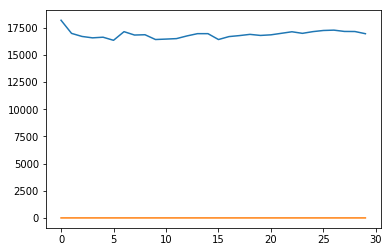

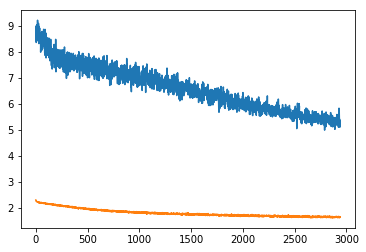

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


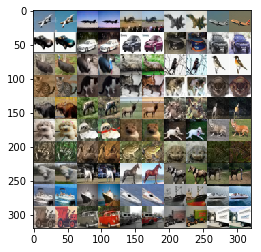

In [54]:
plt.plot(np.arange(0, len(color_errors)), color_errors)
plt.plot(np.arange(0, len(class_errors)), class_errors)
plt.show()       
plt.plot(np.arange(0, len(color_losses)), color_losses)
plt.plot(np.arange(0, len(class_losses)), class_losses)
plt.show()

model.eval()
show_grid(model)

# Download PyTorch model files

In [55]:
from google.colab import files

torch.save(model.state_dict(), 'colorize.pt')
torch.save(model, 'colorize.pickle')
files.download('colorize.pt')
files.download('colorize.pickle')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ColorizeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
